In [1]:
# Import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Dataset directory
dataset_dir = '/content/drive/MyDrive/Diabetes/data_crop'

# Subdirectories for diabetes and healthy images
diabetes_dir = os.path.join(dataset_dir, 'diabetes')
healthy_dir = os.path.join(dataset_dir, 'sehat')

In [ ]:
# Augmented directories
augmented_diabetes_dir = os.path.join(dataset_dir, 'augmented_diabetes')
augmented_healthy_dir = os.path.join(dataset_dir, 'augmented_sehat')

# Directories for augmented data
os.makedirs(augmented_diabetes_dir, exist_ok=True)
os.makedirs(augmented_healthy_dir, exist_ok=True)

# Load diabetes and healthy images
diabetes_images = [os.path.join(diabetes_dir, f) for f in os.listdir(diabetes_dir) if f.endswith(('.jpg', '.png'))]
healthy_images = [os.path.join(healthy_dir, f) for f in os.listdir(healthy_dir) if f.endswith(('.jpg', '.png'))]

print(f"Diabetes images: {len(diabetes_images)}")
print(f"Healthy images: {len(healthy_images)}")

Diabetes images: 725
Healthy images: 708


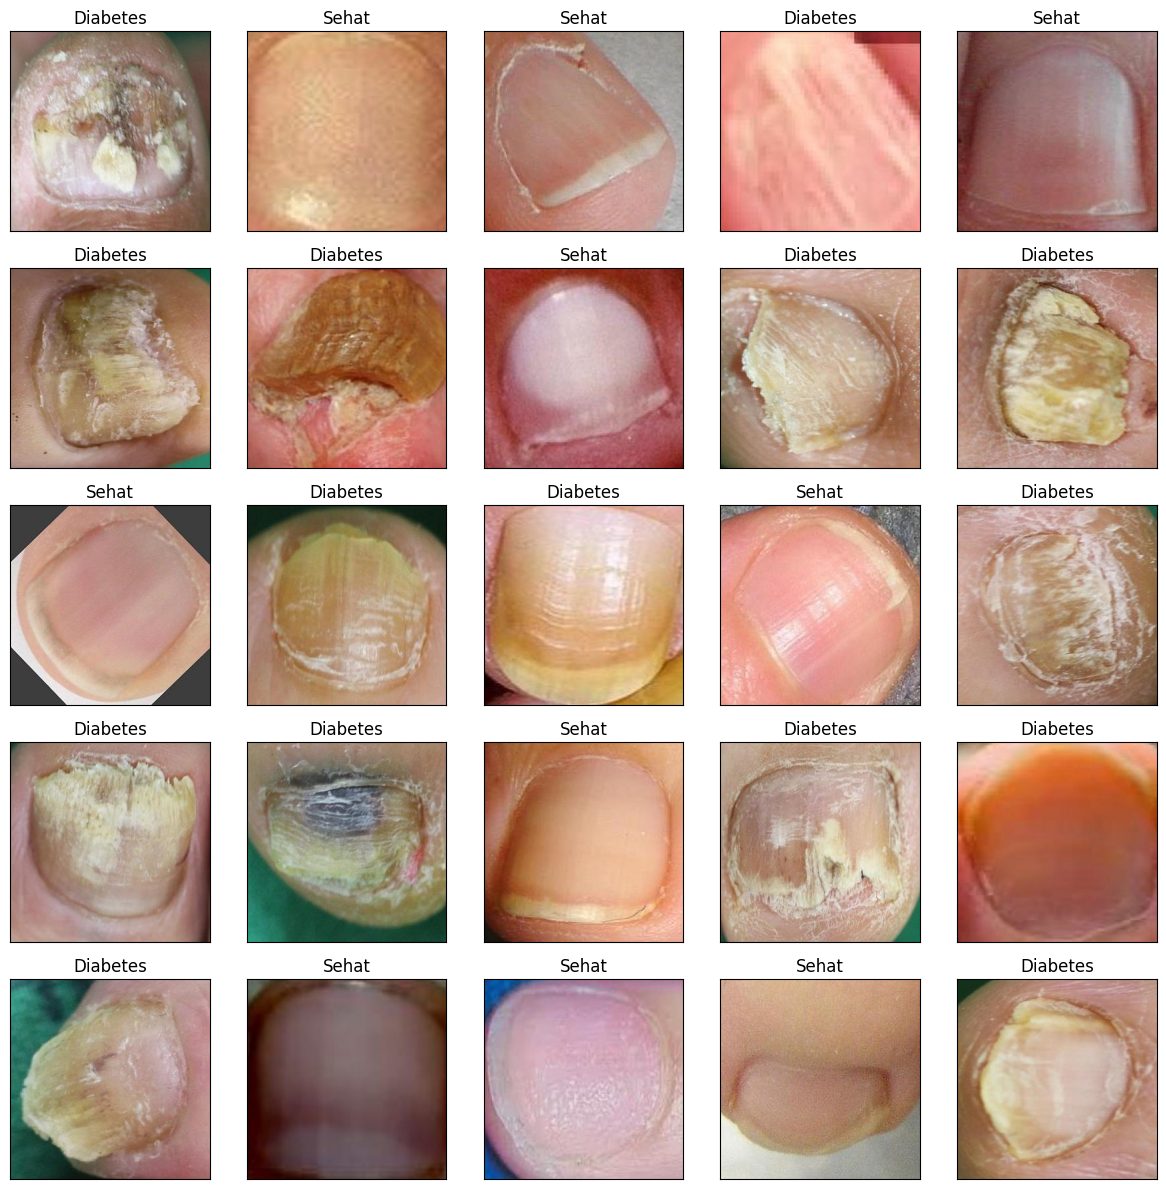

In [ ]:
# Datasets for random sampling
all_images = diabetes_images + healthy_images
labels = ['Diabetes'] * len(diabetes_images) + ['Sehat'] * len(healthy_images)

# Retrieve 25 random images
random_index = np.random.randint(0, len(all_images), 25)
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(12, 12), subplot_kw={'xticks': [], 'yticks': []})

# Display the images
for i, ax in enumerate(axes.flat):
    image_path = all_images[random_index[i]]
    image = Image.open(image_path)
    ax.imshow(image)
    ax.set_title(labels[random_index[i]])

plt.tight_layout()
plt.show()

In [ ]:
# Define augmentation
augment_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=(0.7, 1.3)
)

In [ ]:
# Augment images
def augment_images(images, save_dir, augment_count):
    resized_images = [np.array(Image.open(img).resize((300, 300))) for img in images]
    for i in range(augment_count):
        img_idx = i % len(resized_images)
        img = resized_images[img_idx].reshape((1, 300, 300, 3))
        augmented = next(augment_datagen.flow(img, batch_size=1))[0]
        augmented_img = Image.fromarray(augmented.astype('uint8'))
        augmented_img.save(os.path.join(save_dir, f'aug_img_{i}.jpg'))

# Augment diabetes and healthy images
augment_images(diabetes_images, augmented_diabetes_dir, len(diabetes_images) * 2)
augment_images(healthy_images, augmented_healthy_dir, len(healthy_images) * 2)

In [ ]:
# Combine original and augmented data
all_diabetes_images = diabetes_images + [os.path.join(augmented_diabetes_dir, f) for f in os.listdir(augmented_diabetes_dir)]
all_healthy_images = healthy_images + [os.path.join(augmented_healthy_dir, f) for f in os.listdir(augmented_healthy_dir)]

# Labels: 0 for diabetes, 1 for healthy
diabetes_labels = [0] * len(all_diabetes_images)
healthy_labels = [1] * len(all_healthy_images)

# Combine images and labels
all_images = all_diabetes_images + all_healthy_images
all_labels = diabetes_labels + healthy_labels

In [ ]:
# Train-test split
train_images, test_images, train_labels, test_labels = train_test_split(
    all_images, all_labels, test_size=0.2, stratify=all_labels, random_state=42
)

# Train-validation split
train_images, valid_images, train_labels, valid_labels = train_test_split(
    train_images, train_labels, test_size=0.2, stratify=train_labels, random_state=42
)

print(f"Train: {len(train_images)}, Validation: {len(valid_images)}, Test: {len(test_images)}")

Train: 2751, Validation: 688, Test: 860


In [ ]:
# Image generators
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Convert labels to strings
train_labels_str = ['diabetes' if label == 0 else 'sehat' for label in train_labels]
valid_labels_str = ['diabetes' if label == 0 else 'sehat' for label in valid_labels]
test_labels_str = ['diabetes' if label == 0 else 'sehat' for label in test_labels]

In [ ]:
# Train generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': train_images, 'class': train_labels_str}),
    x_col='filename',
    y_col='class',
    target_size=(300, 300),
    batch_size=32,
    class_mode='binary'
)

# Validation generator
valid_generator = test_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': valid_images, 'class': valid_labels_str}),
    x_col='filename',
    y_col='class',
    target_size=(300, 300),
    batch_size=32,
    class_mode='binary'
)

# Test generator
test_generator = test_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': test_images, 'class': test_labels_str}),
    x_col='filename',
    y_col='class',
    target_size=(300, 300),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 2751 validated image filenames belonging to 2 classes.
Found 688 validated image filenames belonging to 2 classes.
Found 860 validated image filenames belonging to 2 classes.


In [ ]:
# Load MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(300, 300, 3))
base_model.trainable = False

# Add custom layers
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

<ipython-input-31-e8d60a17815c>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(300, 300, 3))


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 10, 10, 1280)        │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# Train the model
callbacks_list = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_accuracy')
]

history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=20,
    callbacks=callbacks_list
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


86/86 ━━━━━━━━━━━━━━━━━━━━ 44s 404ms/step - accuracy: 0.7514 - loss: 0.4888 - val_accuracy: 0.8619 - val_loss: 0.3141
Epoch 2/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 22s 244ms/step - accuracy: 0.8767 - loss: 0.2727 - val_accuracy: 0.9026 - val_loss: 0.2360
Epoch 3/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 21s 227ms/step - accuracy: 0.8942 - loss: 0.2473 - val_accuracy: 0.9113 - val_loss: 0.2145
Epoch 4/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 42s 245ms/step - accuracy: 0.9037 - loss: 0.2305 - val_accuracy: 0.9012 - val_loss: 0.2243
Epoch 5/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 21s 229ms/step - accuracy: 0.9150 - loss: 0.2077 - val_accuracy: 0.9128 - val_loss: 0.2020
Epoch 6/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 41s 230ms/step - accuracy: 0.9329 - loss: 0.1611 - val_accuracy: 0.9230 - val_loss: 0.1952
Epoch 7/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 41s 229ms/step - accuracy: 0.9279 - loss: 0.1781 - val_accuracy: 0.9302 - val_loss: 0.1871
Epoch 8/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 41s 236ms/step - accuracy: 0.9408 - loss: 0.1506 - val_accuracy: 0.927

27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 388ms/step - accuracy: 0.9431 - loss: 0.1513
Test Accuracy: 94.30%
Test Loss: 0.1581
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 242ms/step


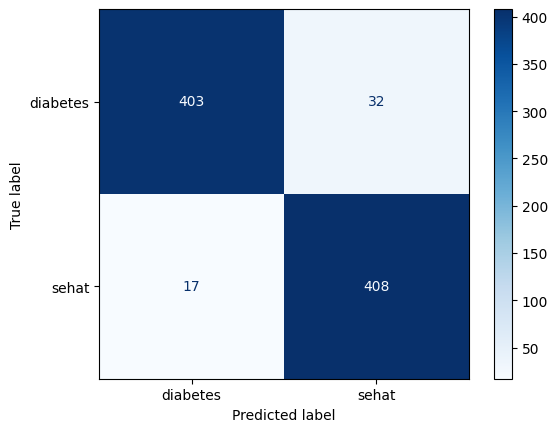

              precision    recall  f1-score   support

           0       0.96      0.93      0.94       435
           1       0.93      0.96      0.94       425

    accuracy                           0.94       860
   macro avg       0.94      0.94      0.94       860
weighted avg       0.94      0.94      0.94       860



In [ ]:
# Evaluate on test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# Predictions
y_true = test_generator.labels
y_pred_probs = model.predict(test_generator)
y_pred = (y_pred_probs > 0.5).astype("int32")

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['diabetes', 'sehat'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Classification report
print(classification_report(y_true, y_pred))

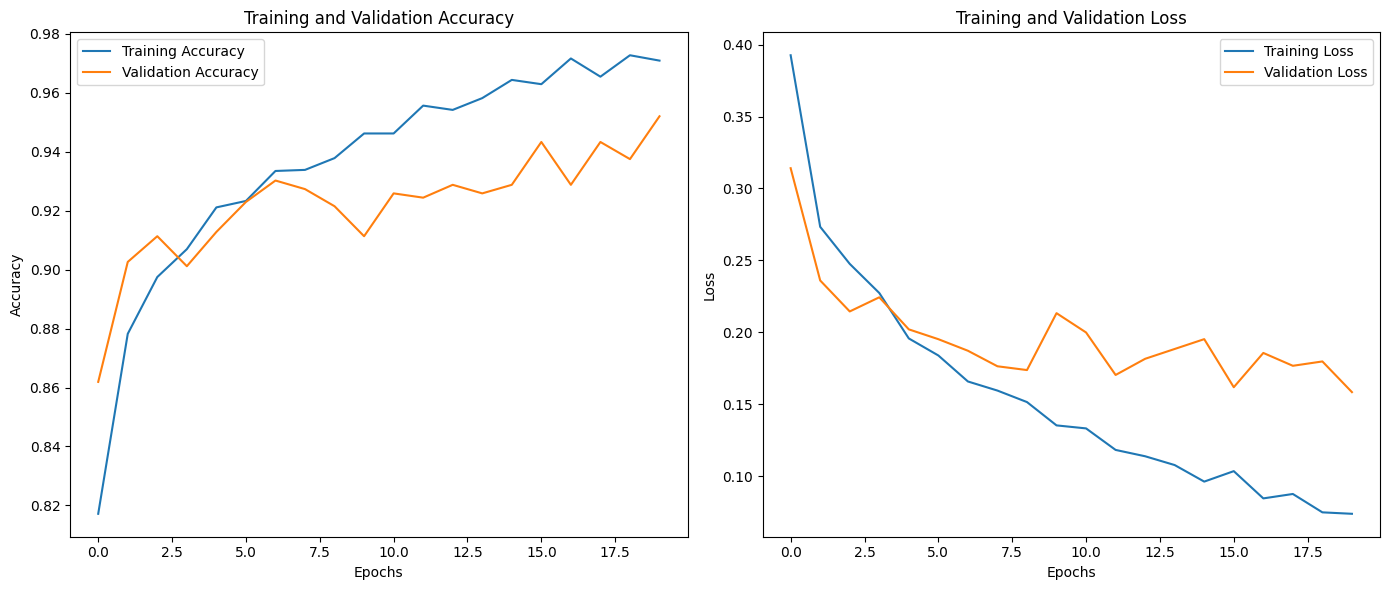

In [ ]:
# Plot accuracy
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

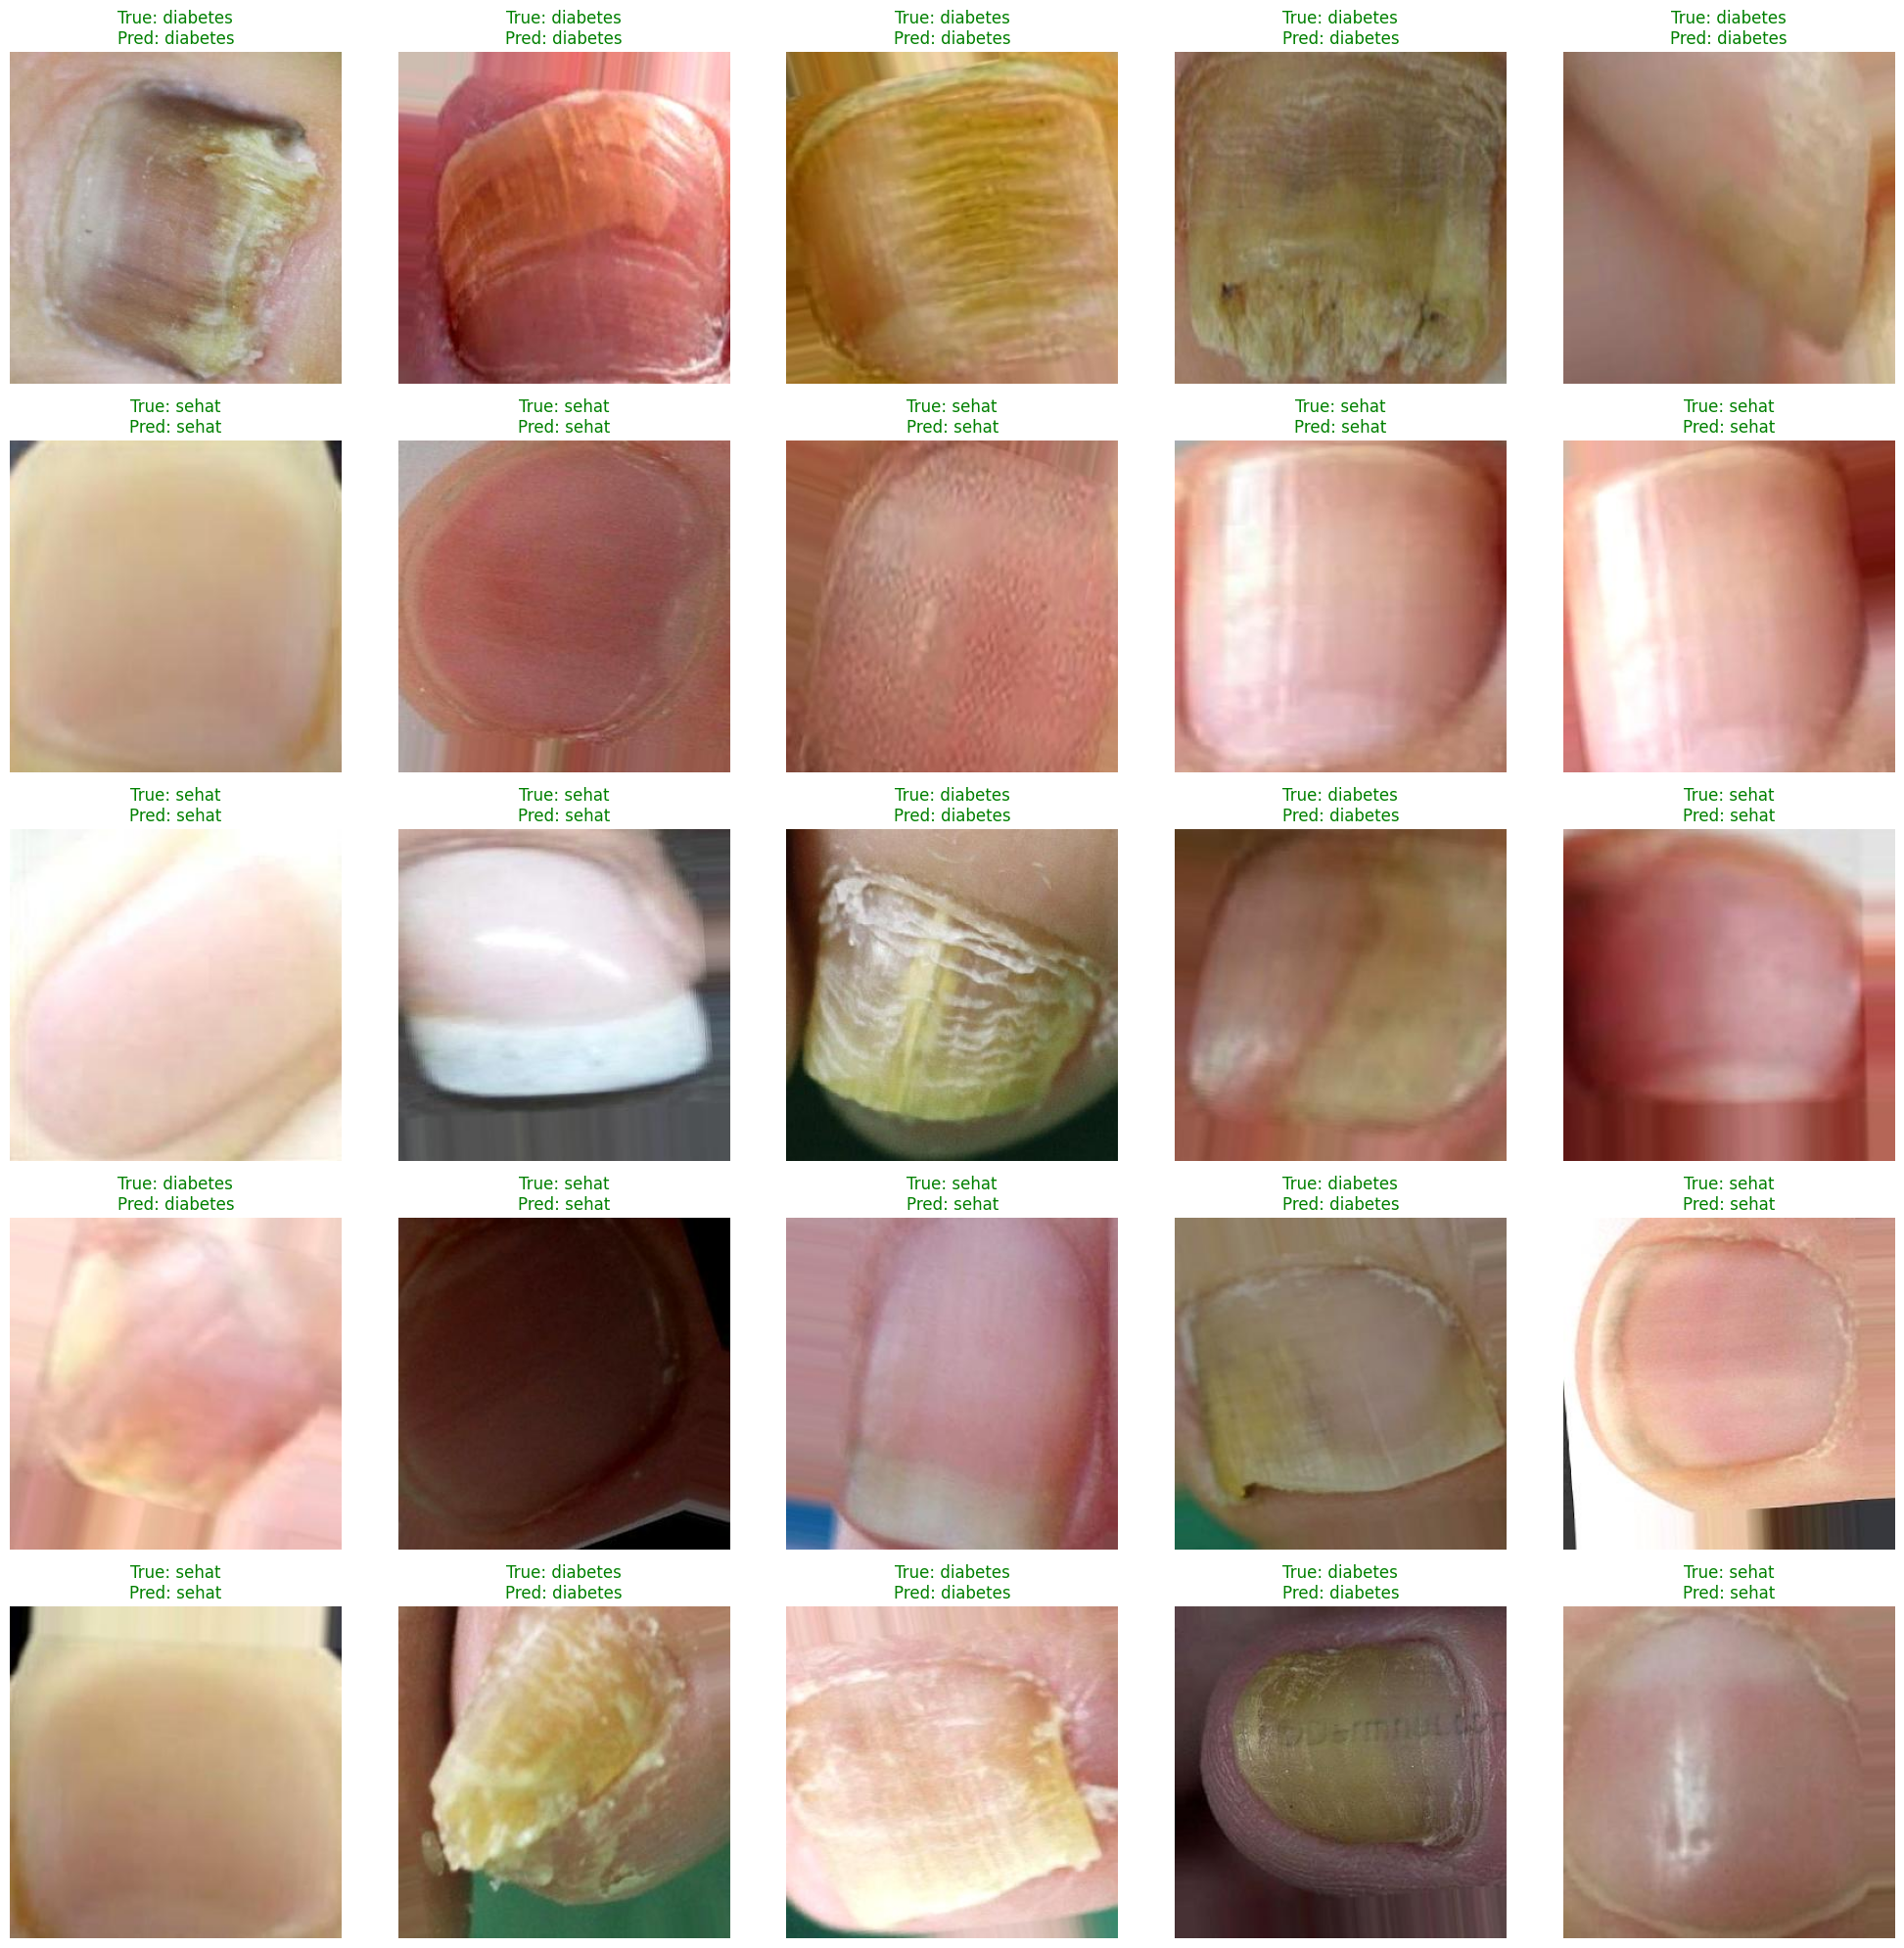

In [ ]:
# Display 25 random prediction results
random_indices = np.random.choice(len(test_generator.filenames), size=25, replace=False)
fig, axes = plt.subplots(5, 5, figsize=(20, 20))

test_filenames = test_generator.filenames
true_labels = ['diabetes' if label == 0 else 'sehat' for label in test_generator.labels]
predicted_labels = ['diabetes' if prob < 0.5 else 'sehat' for prob in y_pred_probs.flatten()]

for i, ax in enumerate(axes.flat):
    idx = random_indices[i]
    img_path = test_filenames[idx]
    true_label = true_labels[idx]
    pred_label = predicted_labels[idx]

    # Read and display the image
    image = Image.open(img_path).resize((300, 300))
    ax.imshow(image)
    ax.axis('off')

    # Set the title color based on prediction accuracy
    color = 'green' if true_label == pred_label else 'red'
    ax.set_title(f"True: {true_label}\nPred: {pred_label}", color=color)

plt.tight_layout()
plt.show()

In [ ]:
# Save model
model.save('/content/drive/MyDrive/Diabetes/cnn_model.keras')
print("Model saved successfully!")

Model saved successfully!
